# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Author*: J.-G. Young <jgyou@umich.edu> <br/>
*Date*: July 2019

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference as pp

In [2]:
import pandas as pd

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [13]:
M=pd.read_csv("M_PL_019_matrix.csv",index_col="Plant")

In [18]:
M=np.array(M)

In [19]:

M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

In [20]:
n_p

40

In [21]:
n_a

85

Let's visualize it:

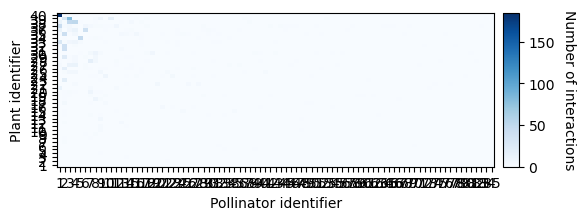

In [22]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [23]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.
Compilation takes a bit of time, but we only need to compile the model once. We are free to re-use it as many times as we like afterwards.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [24]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\jg-you-plant-pollinator-inference-1541aeb\model.bin [Skipping --- already compiled]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [25]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


The warnings above indicate that at least one chain has gotten stuck in a minima.

We can see this by plotting the value of the posterior distribution, evaluated for each samples.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

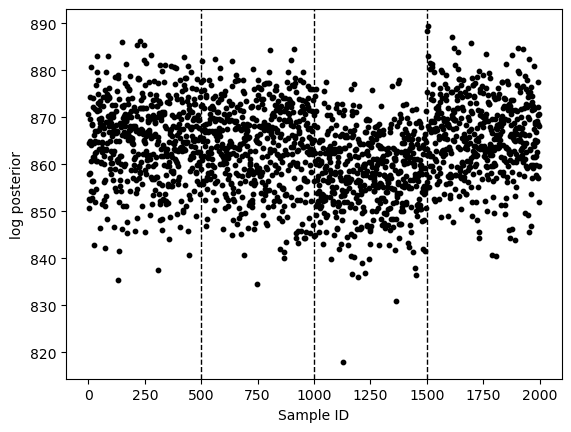

In [26]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

In this particular case, two chains have gotten stuck in an optima with lower posterior probability.

We'll re-run the sampling until we get a clean sample:

In [27]:
while not pp.test_samples(samples, tol=0.05):
    samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

After a few attempt we find a nice set of samples:

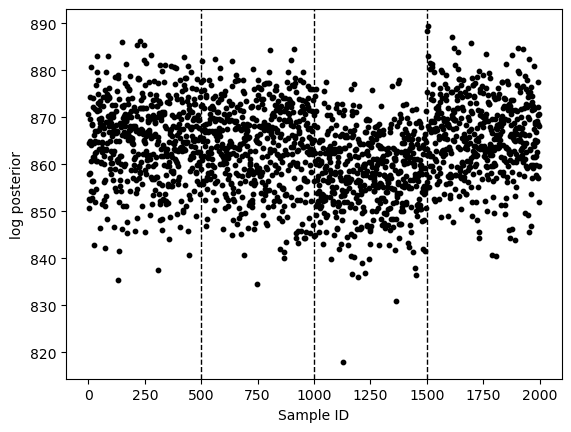

In [28]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Here's the summary of our succesful sampling procedure:

In [29]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C         234.19     nan  22.21 190.46  219.5 233.88 249.37 277.26    nan    nan
r          57.25     nan   7.26  45.13   52.0  56.57  61.68  72.95    nan    nan
sigma[1]  3.4e-3     nan 2.8e-3 3.0e-4 1.4e-3 2.6e-3 4.5e-3   0.01    nan    nan
sigma[2]  3.1e-3     nan 2.7e-3 3.4e-4 1.2e-3 2.3e-3 4.1e-3   0.01    nan    nan
sigma[3]  3.0e-3     nan 2.8e-3 2.7e-4 1.1e-3 2.1e-3 3.9e-3   0.01    nan    nan
sigma[4]  2.8e-3     nan 2.6e-3 2.2e-4 1.1e-3 2.0e-3 3.6e-3   0.01    nan    nan
sigma[5]  5.0e-3     nan 3.5e-3 7.9e-4 2.5e-3 4.2e-3 6.5e-3   0.01    nan    nan
sigma[6]  5.1e-3     nan 3.4e-3 9.7e-4 2.7e-3 4.3e-3 6.7e-3   0.01    nan    nan
sigma[7]  2.3e-3     nan 2.2e-3 3.2e-4 1.0e-

It shows that we can safely ignore the `Rhat` warning, because, as we see, the warning is triggered by the fact that all the samples agree on some entries of the matrix Q.

For example, Q[7,1], is always equal to 1. That is, there is such a strong evidence for the link (7,1) that all samples place an edge between these two nodes. `stan` does not see any variances and  throws a warning. In our case this is by design. 

To see this, let's inspect the entry of the data matrix corresponding to this node pair:

(*Note*: `stan` indices start from 1 not 0. Hence Q[7,1] is associated with M[6,0])

In [30]:
M[6,0]

np.int64(0)

Indeed, we see that there were 30 observations for this entry---no wonder the samples all place an edge between these nodes!

We now have well-behaved samples, let's move on to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [31]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

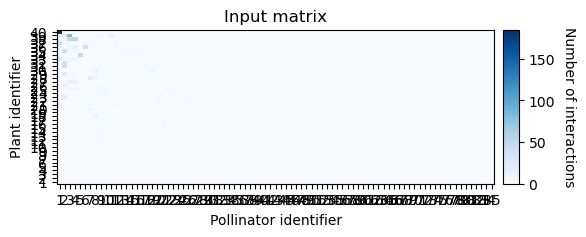

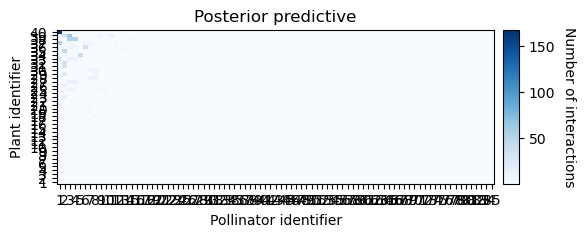

In [35]:
plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

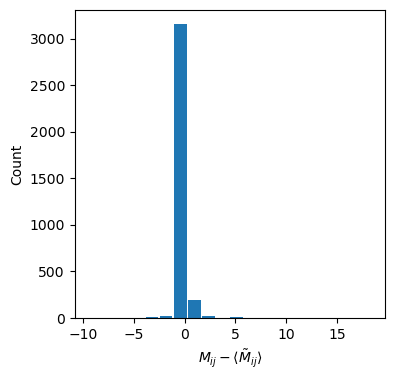

In [38]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

Or compare the posterior predictive value to the input directly:

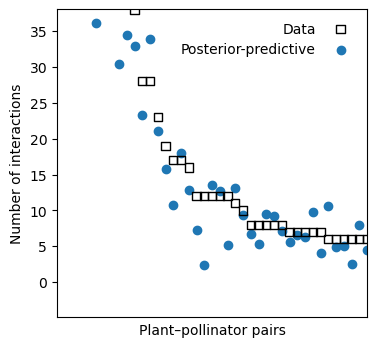

In [39]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)
plt.show()

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [40]:
edge_prob = pp.estimate_network(samples)

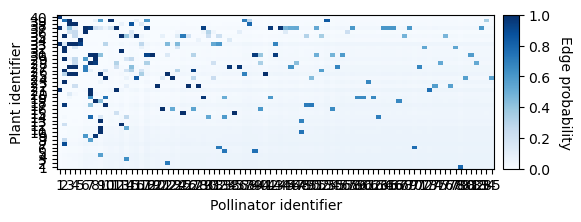

In [41]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()


In [44]:
def plot_subset_interaction_matrices(M, M_tilde, edge_prob, n_p, n_a, subset_n_p, subset_n_a):
    """
    Plots subsets of interaction and edge probability matrices for randomly selected 
    plants and pollinators.

    Args:
        M: Full input interaction matrix.
        M_tilde: Full posterior predictive interaction matrix.
        edge_prob: Full edge probability matrix.
        n_p: Total number of plants.
        n_a: Total number of pollinators.
        subset_n_p: Number of plants to include in the subset plot.
        subset_n_a: Number of pollinators to include in the subset plot.
    """

    if subset_n_p > n_p:
        print(f"Warning: subset_n_p ({subset_n_p}) is larger than n_p ({n_p}). Using n_p instead.")
        subset_n_p = n_p
    if subset_n_a > n_a:
        print(f"Warning: subset_n_a ({subset_n_a}) is larger than n_a ({n_a}). Using n_a instead.")
        subset_n_a = n_a
    if subset_n_p <= 0 or subset_n_a <= 0:
        print("Error: Subset sizes must be positive.")
        return

    # --- Randomly select indices for plants and pollinators ---
    # Use replace=False to ensure unique indices
    plant_indices = np.sort(np.random.choice(range(n_p), size=subset_n_p, replace=False))
    pollinator_indices = np.sort(np.random.choice(range(n_a), size=subset_n_a, replace=False))

    # --- Extract the sub-matrices using the selected indices ---
    # np.ix_ is useful for creating index arrays for sub-matrix selection
    ixgrid = np.ix_(plant_indices, pollinator_indices)
    M_sub = M[ixgrid]
    M_tilde_sub = M_tilde[ixgrid]
    edge_prob_sub = edge_prob[ixgrid]

    # --- Define original labels for the selected subset ---
    plant_labels = plant_indices + 1  # Original identifiers (1-based)
    pollinator_labels = pollinator_indices + 1 # Original identifiers (1-based)

    # --- Helper function for plotting a single matrix subset ---
    def plot_single_subset(matrix_sub, title, colorbar_label, cmap, vmin=None, vmax=None):
        plt.figure(figsize=(6, max(2, 6 * subset_n_p / subset_n_a))) # Adjust aspect ratio
        plt.title(title)
        
        # Use imshow for potentially non-uniform grids or pcolormesh if preferred
        # Using pcolormesh as in the original example
        plt.pcolormesh(matrix_sub, cmap=cmap, vmin=vmin, vmax=vmax)
        
        cb = plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label(colorbar_label, rotation=270)
        
        # Set ticks based on the subset size and labels based on original IDs
        plt.yticks(np.arange(subset_n_p) + 0.5, plant_labels)
        plt.xticks(np.arange(subset_n_a) + 0.5, pollinator_labels, rotation=90) # Rotate if many labels
        
        plt.xlabel('Pollinator identifier')
        plt.ylabel('Plant identifier')
        plt.tight_layout() # Adjust layout to prevent labels overlapping

    # --- Plot the subsets ---
    plot_single_subset(M_sub, 'Input matrix (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(M_tilde_sub, 'Posterior predictive (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(edge_prob_sub, 'Edge probability (Subset)', 'Edge probability', plt.cm.Blues, vmin=0, vmax=1)

    plt.show()

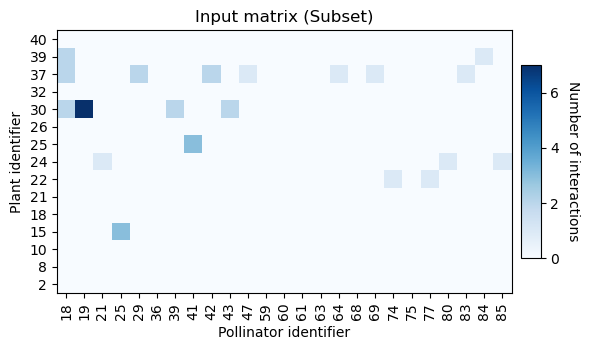

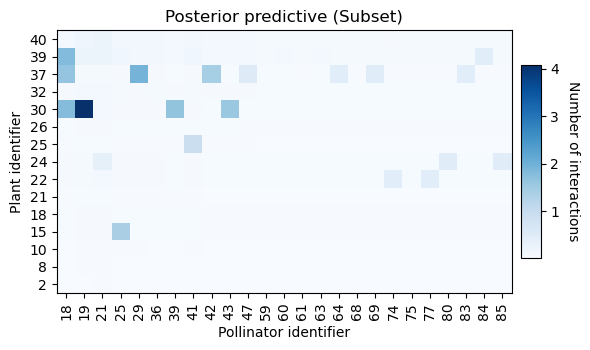

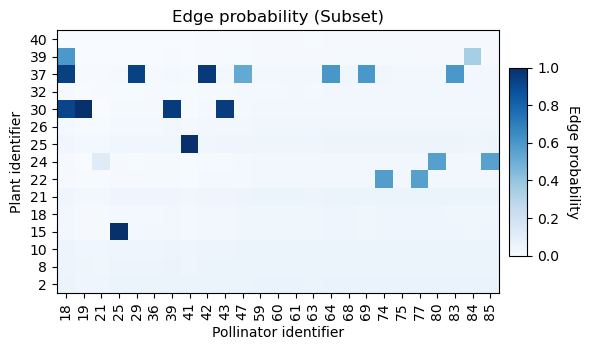

In [45]:
# Define the desired subset size
subset_plants = 15
subset_pollinators = 25

# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_plants, 
    subset_pollinators
)

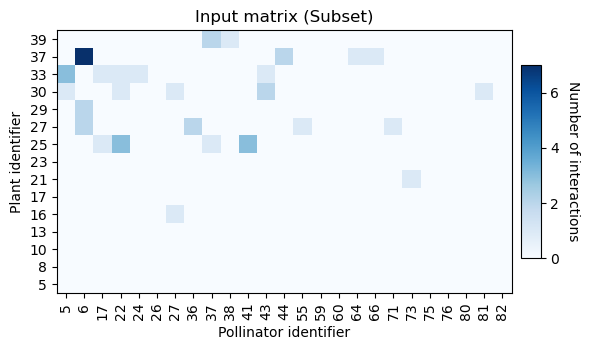

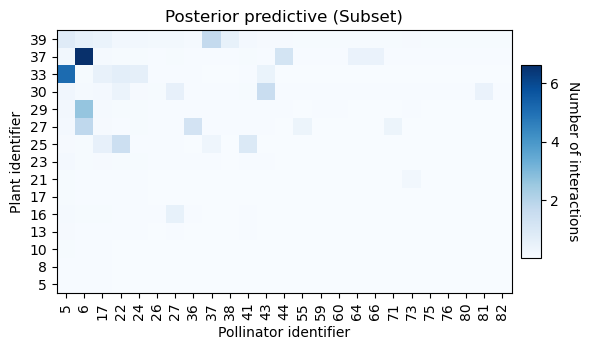

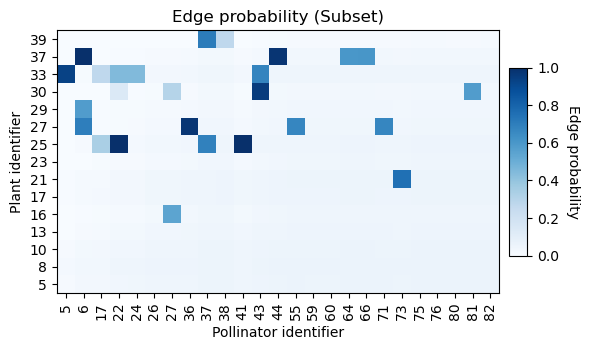

In [46]:
# Define the desired subset size
subset_plants = 15
subset_pollinators = 25

# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_plants, 
    subset_pollinators
)

The parameters themselves are contained in the `samples` object:

In [47]:
samples['rho']

array([0.06181259, 0.08362599, 0.06936607, ..., 0.07031188, 0.06474939,
       0.07735368])

So we can, for example, visualize posterior distributions as:

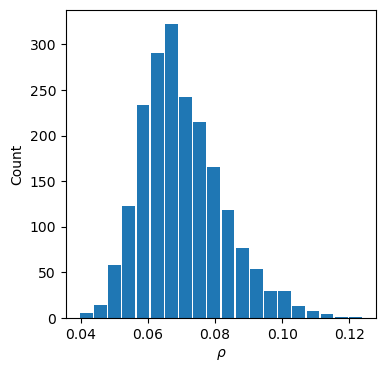

In [48]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')
plt.show()

And find posterior averages with:

In [49]:
print('Posterior average of the connectance:', np.mean(samples['rho'], axis=0))

Posterior average of the connectance: 0.07029421726384615


The same thing goes for, say, the plant abundances (now a dimension `samples * n_p` object---hence why we average along the axis 0, the `samples` axis):

In [50]:
mean_sigma = np.mean(samples['sigma'], axis=0)

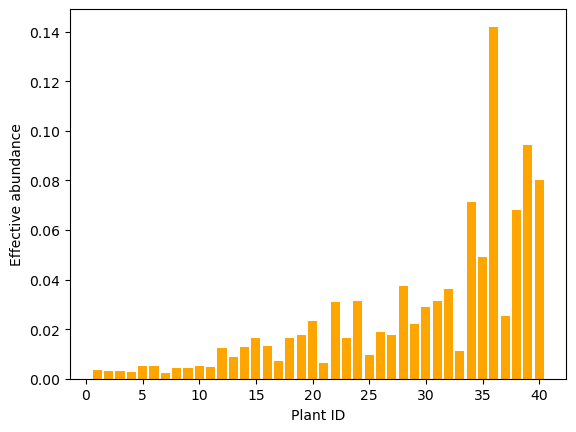

In [51]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')
plt.show()

We can do the same with the pollinators:

In [52]:
mean_tau = np.mean(samples['tau'], axis=0)

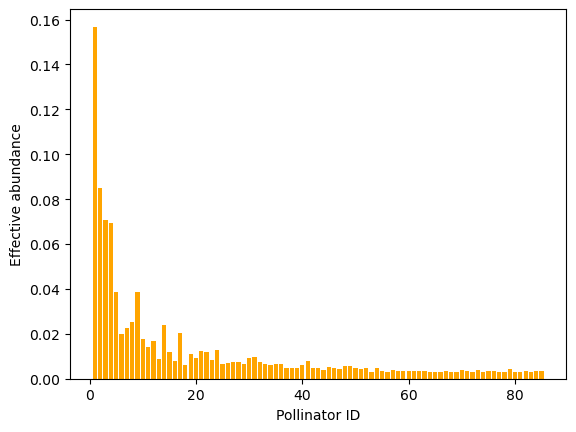

In [53]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')
plt.show()

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [54]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [55]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

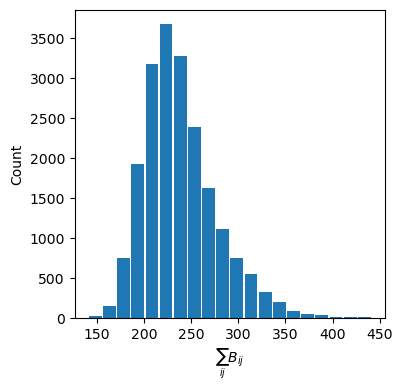

In [56]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')
plt.show()